In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Usar tamaño acorde a VGG16 mínimo 224x224, mejor 256x256
IMG_SIZE = (256, 256)

# Definir rutas
train_dir = '../data/Training'
test_dir = '../data/Testing'

# Crear generadores con split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',  
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


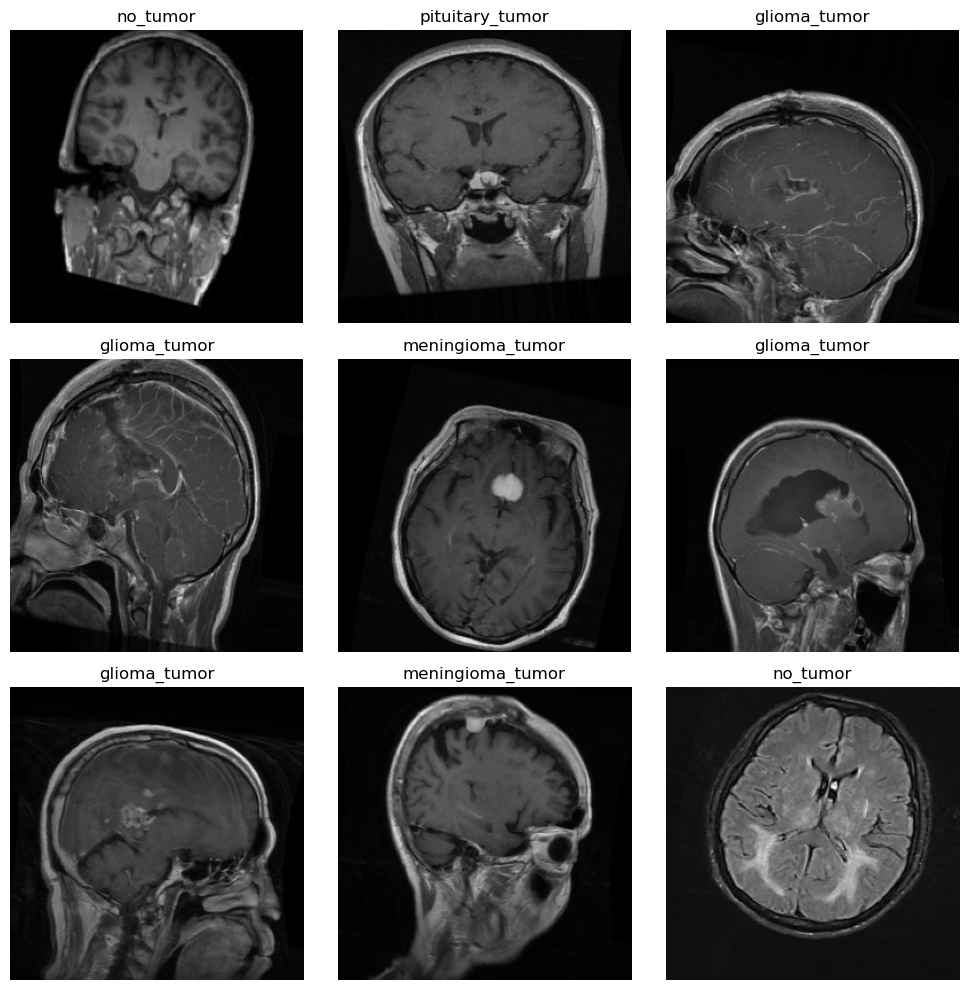

In [2]:
images, labels = next(train_generator)

class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    label_index = np.argmax(labels[i])
    plt.title(class_names[label_index])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16 # Modelo preentrenado de Keras
from tensorflow.keras.models import Model # Para definir un modelo CNN
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input # Capas que van despues de VGG16

base_model = VGG16(
    weights='imagenet', # Usa pesos entrenados con ImageNet.
    include_top=False, # No carga las capas densas finales (clasificador original).
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)  # Imagen de entrada: ancho, alto, 3 canales (RGB).
)

base_model.trainable = False # Congelar capas base. Sus pesos no se ajustan durante el entrenamiento, solo se ajustan las capas nuevas.

# Añadir capas personalizadas
x = base_model.output # Empezamos por la salida de VGG16
x = GlobalAveragePooling2D()(x)  # Hace el modelo más robusto que usar Flatten, porque GAP reduce parámetros y evita overfitting
x = Dense(128, activation='relu')(x) # Añade una capa densa con 128 neuronas y activación ReLU
x = Dropout(0.5)(x) # Apaga aleatoriamente el 50% de las neuronas en cada batch. Evita overfitting, forzando a no depender de neuronas concretas.
output = Dense(4, activation='softmax')(x) # Dense(4): 4 neuronas, una por clase. Softmax: convierte las salidas en probabilidades que suman 1.

model = Model(inputs=base_model.input, outputs=output) # Entrada = la entrada de VGG16. Salida = Nueva capa Dense(4).

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [4]:
# Importa dos callbacks útiles de Keras:
# EarlyStopping: para parar el entrenamiento si no mejora.
# ReduceLROnPlateau: para reducir la tasa de aprendizaje si se estanca.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Monitorea la métrica 'val_loss' (la pérdida en validación).
# Si no mejora durante 5 epochs seguidos, para el entrenamiento.
# Además, restaura automáticamente los mejores pesos logrados.
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Si la 'val_loss' no mejora durante 'patience=3' epochs, reduce la tasa de aprendizaje a la mitad ('factor=0.5').
# Así puede encontrar un mejor mínimo si se atasca.
# 'min_lr' evita que baje demasiado
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Guarda el histórico en 'history' para analizar resultados luego.
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

E:\Programas\Anaconda\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.3415 - loss: 1.4074 - val_accuracy: 0.4276 - val_loss: 1.1728 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.5543 - loss: 1.0930 - val_accuracy: 0.5445 - val_loss: 1.0399 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.6747 - loss: 0.9029 - val_accuracy: 0.6091 - val_loss: 0.9469 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.6848 - loss: 0.8301 - val_accuracy: 0.6353 - val_loss: 0.8882 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.7093 - loss: 0.7569 - val_accuracy: 0.6108 - val_loss: 0.8706 - learning_rate: 0.0010
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.7363 - loss: 0.6949 - val_accuracy: 0.6719 - val_loss: 0.8132 - learning_rate: 0.0010
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.7471 - loss: 0.6742 - val_acc

In [8]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

resultados = model.evaluate(test_generator)

print(resultados) 

test_loss = resultados[0]
test_accuracy = resultados[1]

print(f'Pérdida en test: {test_loss:.4f}')
print(f'Accuracy en test: {test_accuracy:.4f}')

Found 394 images belonging to 4 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3774 - loss: 2.3318
[1.5465538501739502, 0.5329949259757996]
Pérdida en test: 1.5466
Accuracy en test: 0.5330
